In [1]:
import os
import time
import uuid
import cv2

In [5]:
IMAGES_PATH =os.path.join('data','images')
number_images = 2

In [7]:

cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

2023-10-10 11:07:20.502 python[11266:93241] WARNING: AVCaptureDeviceTypeExternal is deprecated for Continuity Cameras. Please use AVCaptureDeviceTypeContinuityCamera and add NSCameraUseContinuityCameraDeviceType to your Info.plist.


collecting image 0
collecting image 1


In [2]:
!labelme

[INFO   ] __init__:get_config:70 - Loading config file from: /Users/aoamacsplace/.labelmerc


In [3]:
import tensorflow as tf
import cv2
import json
import numpy as np
import matplotlib.pyplot as plt

In [10]:
images = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/data/images/*.jpg', shuffle=False)


In [11]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [13]:
images = images.map(load_image)

In [14]:
images.as_numpy_iterator().next()

array([[[ 78,  59,  44],
        [ 78,  59,  44],
        [ 80,  61,  46],
        ...,
        [129, 113,  87],
        [119, 103,  77],
        [109,  93,  67]],

       [[ 80,  61,  46],
        [ 80,  61,  46],
        [ 81,  62,  47],
        ...,
        [128, 112,  86],
        [120, 104,  78],
        [112,  96,  70]],

       [[ 81,  62,  47],
        [ 80,  61,  46],
        [ 81,  62,  47],
        ...,
        [132, 116,  90],
        [128, 113,  84],
        [124, 109,  80]],

       ...,

       [[125, 110,  79],
        [125, 110,  79],
        [126, 109,  79],
        ...,
        [ 94,  77,  57],
        [ 93,  76,  58],
        [ 92,  75,  57]],

       [[122, 107,  76],
        [123, 108,  77],
        [125, 108,  78],
        ...,
        [ 94,  77,  57],
        [ 93,  76,  56],
        [ 92,  75,  55]],

       [[118, 103,  72],
        [121, 106,  75],
        [125, 108,  78],
        ...,
        [ 96,  79,  59],
        [ 95,  78,  58],
        [ 94,  77,  57]]

In [16]:
image_generator = images.batch(4).as_numpy_iterator()

In [25]:
plot_images = image_generator.next()

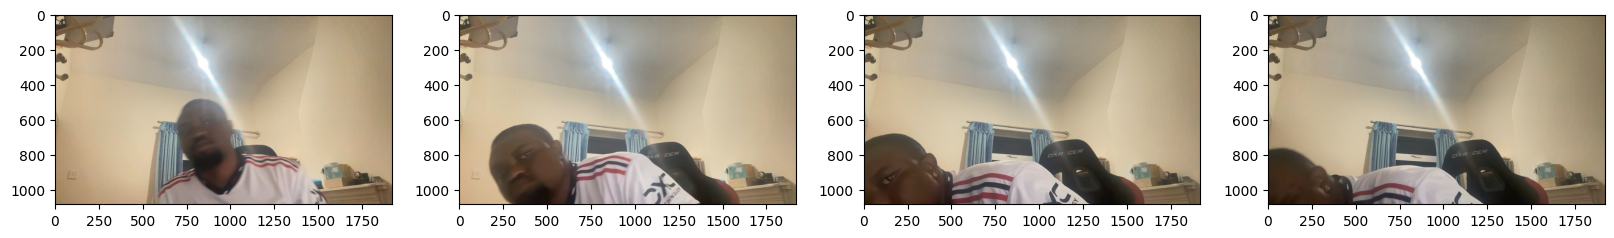

In [26]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

In [27]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data',folder,'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, filename)
            os.replace(existing_filepath, new_filepath)

In [43]:
image.shape

(1080, 1920, 3)

In [28]:
import albumentations as alb

In [87]:
augumentor = alb.Compose([alb.RandomCrop(width=800, height=800),
                          alb.HorizontalFlip(p=0.5), 
                          alb.RandomBrightnessContrast(p=0.2),
                          alb.RandomGamma(p=0.2), 
                          alb.RGBShift(p=0.2), 
                          alb.VerticalFlip(p=0.5)],
                          bbox_params=alb.BboxParams(format='albumentations', 
                                                     label_fields=['class_labels']))
                                                     

In [88]:
img = cv2.imread(os.path.join('data','train','images','c50e4480-66e3-11ee-bba1-4a240ef18c07.jpg'))

In [89]:
with open(os.path.join('data','train','labels','c50e4480-66e3-11ee-bba1-4a240ef18c07.json'), 'r') as f:
    label = json.load(f)

In [90]:
label['shapes'][0]['points']

[[686.4705882352941, 351.7647058823529],
 [1227.6470588235293, 928.235294117647]]

In [91]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [92]:
coords

[686.4705882352941, 351.7647058823529, 1227.6470588235293, 928.235294117647]

In [93]:
coords = list(np.divide(coords, [1920,1080,1920,1080]))
coords

[0.35753676470588236,
 0.32570806100217864,
 0.6393995098039215,
 0.8594771241830065]

In [94]:
augumented = augumentor(image=img, bboxes=[coords],class_labels=['face'])

In [95]:
augumented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [96]:
augumented['image'].shape

(800, 800, 3)

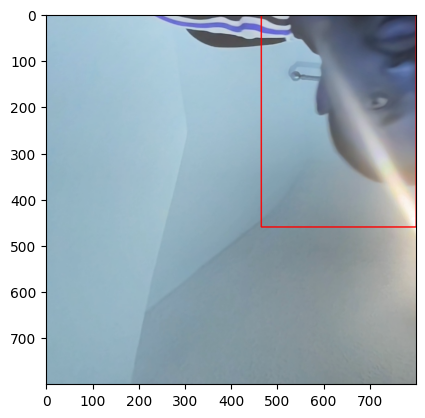

In [97]:
cv2.rectangle(augumented['image'],
              tuple(np.multiply(augumented['bboxes'][0][:2],[800,800]).astype(int)),
              tuple(np.multiply(augumented['bboxes'][0][2:],[800,800]).astype(int)),
                    (255,0,0),2)
plt.imshow(augumented['image'])

In [98]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1920,1080,1920,1080]))

        try: 
            for x in range(60):
                augmented = augumentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

image must be numpy array type
x_max is less than or equal to x_min for bbox [0.3177083333333333, 0.45642701525054463, 0.018513698796350297, 0.9990740740740741, 'face'].
x_max is less than or equal to x_min for bbox [0.7680759803921569, 0.690631808278867, 0.4923406862745098, 0.3202614379084967, 'face'].
x_max is less than or equal to x_min for bbox [0.31464460784313725, 0.9956427015250546, 0.0, 0.5840321453528999, 'face'].


In [103]:
train_images = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (200,200)))
train_images = train_images.map(lambda x: x/255)

In [104]:
test_images = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (200,200)))
test_images = test_images.map(lambda x: x/255)

In [105]:
val_images = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (200,200)))
val_images = val_images.map(lambda x: x/255)


In [106]:
train_images.as_numpy_iterator().next()

array([[[0.5107843 , 0.48333332, 0.36960784],
        [0.50980395, 0.48235294, 0.36862746],
        [0.5176471 , 0.47843137, 0.37254903],
        ...,
        [0.59705883, 0.5686275 , 0.46960783],
        [0.6       , 0.5686275 , 0.47843137],
        [0.59607846, 0.5647059 , 0.4745098 ]],

       [[0.52156866, 0.4862745 , 0.37254903],
        [0.52156866, 0.4862745 , 0.37254903],
        [0.5235294 , 0.48431373, 0.37843138],
        ...,
        [0.59607846, 0.5656863 , 0.47254902],
        [0.59607846, 0.5647059 , 0.4745098 ],
        [0.59607846, 0.5647059 , 0.4745098 ]],

       [[0.51666665, 0.48333332, 0.36960784],
        [0.5156863 , 0.4882353 , 0.3745098 ],
        [0.5156863 , 0.4852941 , 0.3764706 ],
        ...,
        [0.59607846, 0.5647059 , 0.4745098 ],
        [0.6019608 , 0.57058823, 0.48039216],
        [0.59607846, 0.5647059 , 0.4745098 ]],

       ...,

       [[0.10392157, 0.05686275, 0.00980392],
        [0.10588235, 0.05882353, 0.01176471],
        [0.10294118, 0

In [107]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [108]:
train_labels = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
test_labels = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
val_labels = tf.data.Dataset.list_files('/Users/aoamacsplace/Documents/DS-Projects/face-detection/aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))
train_labels.as_numpy_iterator().next()


(array([1], dtype=uint8),
 array([0.    , 0.2686, 0.3877, 0.96  ], dtype=float16))

In [109]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(5160, 5160, 1440, 1440, 900, 900)

In [110]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [0],
        [0],
        [0],
        [0],
        [0]], dtype=uint8),
 array([[0.4766, 0.3264, 1.    , 0.929 ],
        [0.4336, 0.4941, 0.985 , 1.    ],
        [0.    , 0.    , 0.735 , 0.4705],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


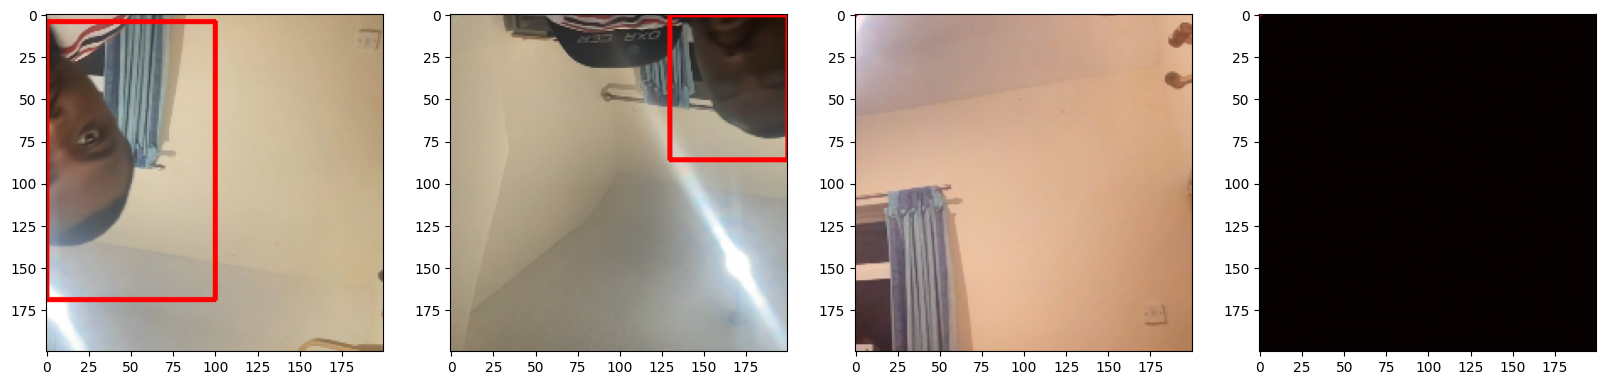

In [118]:
data_samples = train.as_numpy_iterator()
res = data_samples.next()
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [200,200]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [200,200]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)
    

In [119]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [120]:
vgg = VGG16(include_top=False)
vgg.summary()

58889256/58889256 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [121]:
def build_model(): 
    input_layer = Input(shape=(200,200,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker


In [122]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [0],
        [1],
        [1]], dtype=uint8),
 array([[0.2002 , 0.3179 , 0.9136 , 0.965  ],
        [0.     , 0.3723 , 0.4539 , 1.     ],
        [0.     , 0.0888 , 0.1904 , 0.6846 ],
        [0.7964 , 0.1575 , 1.     , 0.8193 ],
        [0.351  , 0.     , 1.     , 0.526  ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.3472 , 0.2893 , 1.     , 0.8335 ],
        [0.656  , 0.03044, 1.     , 0.854  ]], dtype=float16))

In [123]:
facetracker = build_model()
facetracker.summary()
X, y = train.as_numpy_iterator().next()
X.shape
classes, coords = facetracker.predict(X)
classes, coords


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

(array([[0.62205523],
        [0.646161  ],
        [0.56883913],
        [0.63410705],
        [0.5333912 ],
        [0.5913996 ],
        [0.5590008 ],
        [0.57264817]], dtype=float32),
 array([[0.55942255, 0.42449927, 0.69600254, 0.53153753],
        [0.48387006, 0.45191762, 0.6324287 , 0.47015262],
        [0.5665392 , 0.45167014, 0.5997124 , 0.5083242 ],
        [0.58836347, 0.39520147, 0.58439785, 0.56600964],
        [0.6327594 , 0.4284834 , 0.62109554, 0.5127532 ],
        [0.47047403, 0.4586708 , 0.5314777 , 0.4750181 ],
        [0.6143965 , 0.37436202, 0.5535587 , 0.49345586],
        [0.57711774, 0.4097287 , 0.58022046, 0.59907657]], dtype=float32))

In [126]:
len(train)

645

In [125]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)



In [127]:
lr_decay

0.0005167958656330748

In [128]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [129]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss


In [131]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=7.1196003>

In [132]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.6205755>

In [133]:

regressloss(y[1], coords)



<tf.Tensor: shape=(), dtype=float32, numpy=7.1196003>

In [134]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)
model = FaceTracker(facetracker)
model.compile(opt, classloss, regressloss)

In [136]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [137]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/10
645/645 [==============================] - 1120s 2s/step - total_loss: 1.1912 - class_loss: 0.3488 - regress_loss: 1.0168 - val_total_loss: 0.3399 - val_class_loss: 0.1034 - val_regress_loss: 0.2882
Epoch 2/10
645/645 [==============================] - 1114s 2s/step - total_loss: 0.6209 - class_loss: 0.1966 - regress_loss: 0.5226 - val_total_loss: 0.0923 - val_class_loss: 0.0033 - val_regress_loss: 0.0906
Epoch 3/10
645/645 [==============================] - 1117s 2s/step - total_loss: 0.3878 - class_loss: 0.1126 - regress_loss: 0.3315 - val_total_loss: 1.4048 - val_class_loss: 0.8308 - val_regress_loss: 0.9894
Epoch 4/10
645/645 [==============================] - 1105s 2s/step - total_loss: 0.2820 - class_loss: 0.0857 - regress_loss: 0.2392 - val_total_loss: 0.9821 - val_class_loss: 0.4905 - val_regress_loss: 0.7368
Epoch 5/10
524/645 [=======================>......] - ETA: 3:19 - total_loss: 0.2115 - class_loss: 0.0649 - regress_loss: 0.1791

In [ ]:
hist.history
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()
test_sample = test_data.next()
yhat = facetracker.predict(test_sample[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model
facetracker.save('facetracker.h5')
facetracker = load_model('facetracker.h5')

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()